In [1]:
!pip install cyvcf2

In [2]:
from cyvcf2 import VCF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parents[2] / "src" / "python"))
from paths import training_path
from vcf_helpers import normalize_vcf_features, extract_variant_features, cleanup_dataframe

In [3]:
vcf_path = training_path / "training_hg38.vcf"

In [4]:
info_fields = [
    "AS_UNIQ_ALT_READ_COUNT", "CONTQ", "DP", "ECNT", "GERMQ",
    "MBQ", "MFRL", "MMQ", "MPOS", "NALOD", "NCount", "NLOD", "OCM", "PON",
    "POPAF", "ROQ", "SEQQ", "STRANDQ", "STRQ", "TLOD", "GOLDEN"
]

format_fields = [
    "AD", "AF", "DP", "F1R2", "F2R1", "GQ", "PL", "SB"
]

split_ref_alt_fields = {"AD", "AF", "F1R2", "F2R1", "SB"}

split_info_ref_alt = {"MBQ", "MFRL", "MMQ"}

In [5]:
# Load VCF
vcf = VCF(vcf_path)
sample_names = vcf.samples
print(sample_names)

['HG008-N', 'HG008-T']


In [6]:
# Identify tumor sample
tumor_sample_index = None
tumor_sample_name = None

if len(sample_names) == 1:
    tumor_sample_index = 0
    tumor_sample_name = sample_names[0]
else:
    for idx, name in enumerate(sample_names):
        if "-T" in name or "tumor" in name.lower() or "tumour" in name.lower():
            tumor_sample_index = idx
            tumor_sample_name = name
            break

    if tumor_sample_index is None:
        raise ValueError("Could not identify tumor sample. Make sure tumor sample ID contains '-T' or 'tumor'.")

print(f"Using tumor sample: {tumor_sample_name}")

Using tumor sample: HG008-T


In [7]:
df = extract_variant_features(vcf, info_fields, format_fields, split_info_ref_alt, split_ref_alt_fields, tumor_sample_index)

In [8]:
df.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'AS_UNIQ_ALT_READ_COUNT', 'CONTQ', 'DP',
       'ECNT', 'GERMQ', 'MBQ_ref', 'MBQ_alt', 'MFRL_ref', 'MFRL_alt',
       'MMQ_ref', 'MMQ_alt', 'MPOS', 'NALOD', 'NCount', 'NLOD', 'OCM', 'PON',
       'POPAF', 'ROQ', 'SEQQ', 'STRANDQ', 'STRQ', 'TLOD', 'GOLDEN', 'AD_ref',
       'AD_alt', 'AF', 'F1R2_ref', 'F1R2_alt', 'F2R1_ref', 'F2R1_alt', 'GQ',
       'PL'],
      dtype='object')

In [9]:
df = cleanup_dataframe(df)


 Dropped empty or excluded columns:
 - AS_UNIQ_ALT_READ_COUNT
 - CONTQ
 - GERMQ
 - GQ
 - NCount
 - OCM
 - PL
 - PON
 - ROQ
 - SEQQ
 - STRANDQ
 - STRQ
 - POPAF


In [10]:
df["GOLDEN"] = df["GOLDEN"].fillna(False).astype(int)

df = normalize_vcf_features(df)

output_path = training_path / "vcf_feature_vectors.csv"
df.to_csv(output_path, index=False)
print(f"Saved cleaned, split, normalized features to: {output_path}")

/tmp/ipykernel_300726/1965979040.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["GOLDEN"] = df["GOLDEN"].fillna(False).astype(int)


Saved cleaned, split, normalized features to: /home/kourisa/thesis/ml_filter/data/training/vcf_feature_vectors.csv


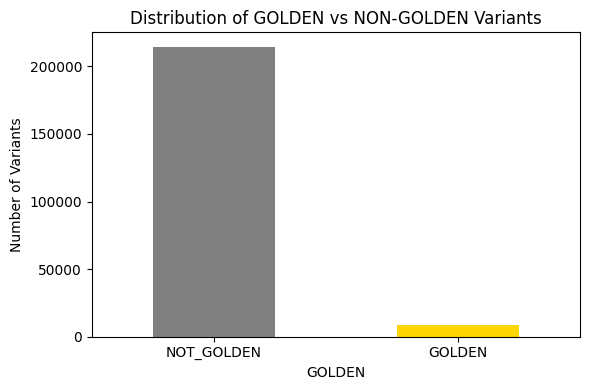

In [11]:
# Check if the 'GOLDEN' column exists, and treat it as a binary flag (1 if present, 0 otherwise)
if 'GOLDEN' in df.columns:
    golden_counts = df['GOLDEN'].fillna(0).astype(bool).value_counts().rename({True: 'GOLDEN', False: 'NOT_GOLDEN'})

    # Plot the distribution
    plt.figure(figsize=(6, 4))
    golden_counts.plot(kind='bar', color=['gray', 'gold'])
    plt.title("Distribution of GOLDEN vs NON-GOLDEN Variants")
    plt.ylabel("Number of Variants")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_violin_and_box(df, feature_groups):    
    for name, cols in feature_groups.items():
        cols = [col for col in cols if col in df.columns]
        if not cols:
            continue

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(len(cols) * 0.6 * 2, 5), sharey=True)

        # Box plot
        sns.boxplot(data=df[cols], ax=axes[0])
        axes[0].set_title(f"{name} Features - Boxplot")
        axes[0].tick_params(axis='x', rotation=45)

        # Violin plot
        sns.violinplot(data=df[cols], ax=axes[1])
        axes[1].set_title(f"{name} Features - Violinplot")
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

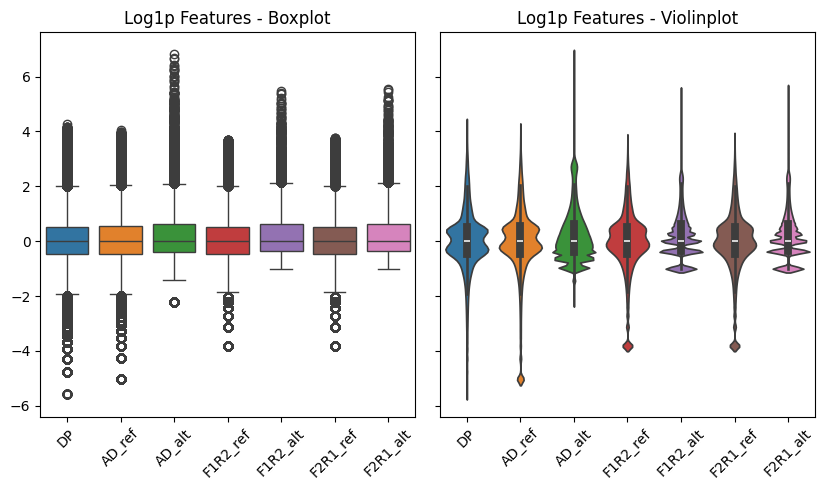

In [13]:
log1p_cols = [
    "DP", "AD_ref", "AD_alt", "FAD_ref", "FAD_alt",
    "F1R2_ref", "F1R2_alt", "F2R1_ref", "F2R1_alt",
    "SB_ref_fwd", "SB_ref_rev", "SB_alt_fwd", "SB_alt_rev",
    "AS_SB_ref_fwd", "AS_SB_ref_rev", "AS_SB_alt_fwd", "AS_SB_alt_rev"
]

plot_violin_and_box(df, {
    "Log1p": log1p_cols
})

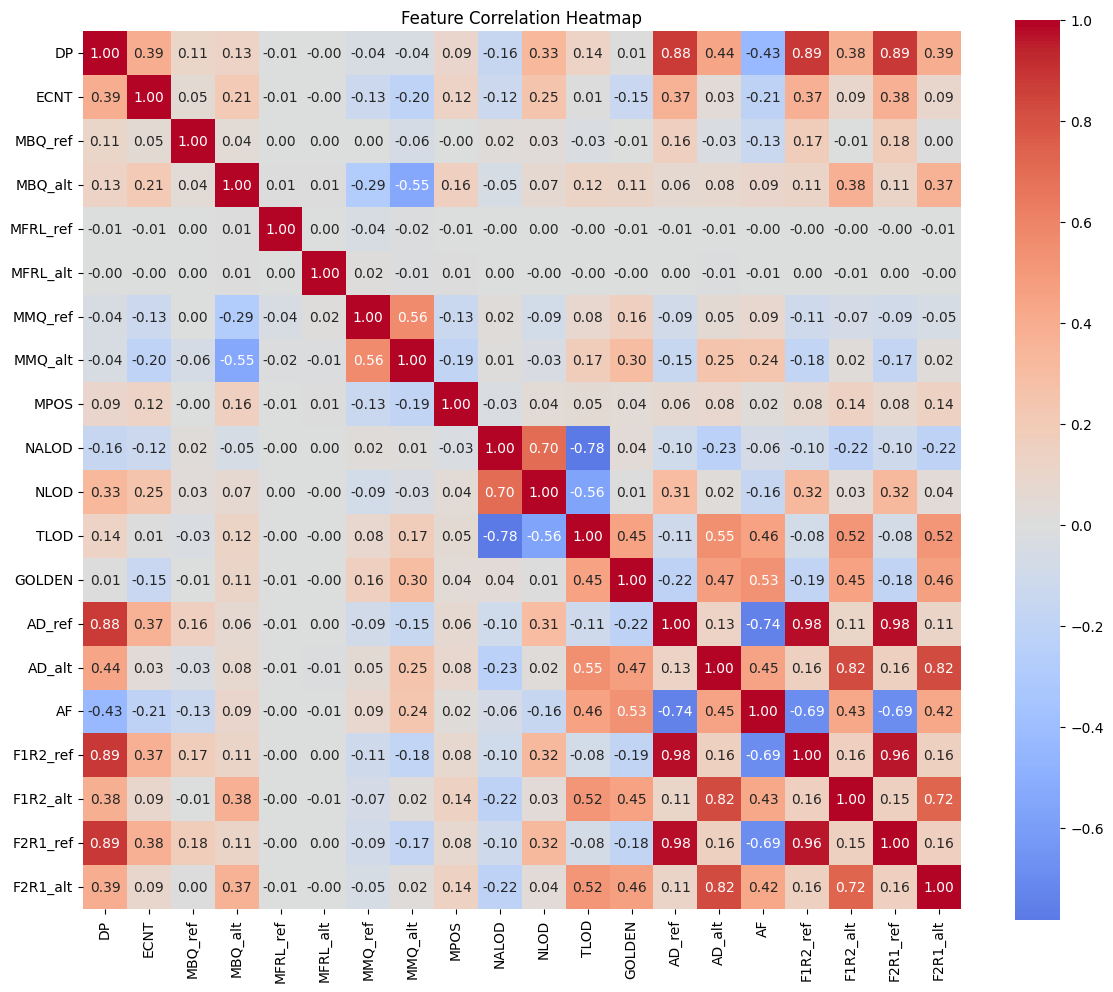

In [14]:
df_corr = df.drop(columns=["CHROM", "POS", "REF", "ALT"])
df_corr = df_corr.select_dtypes(include=[np.number])

corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

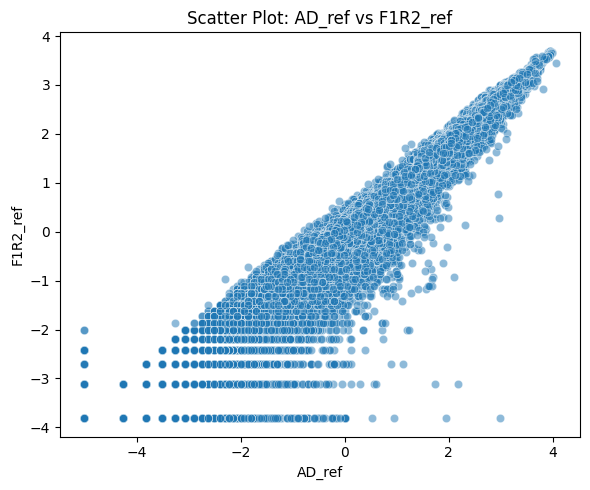

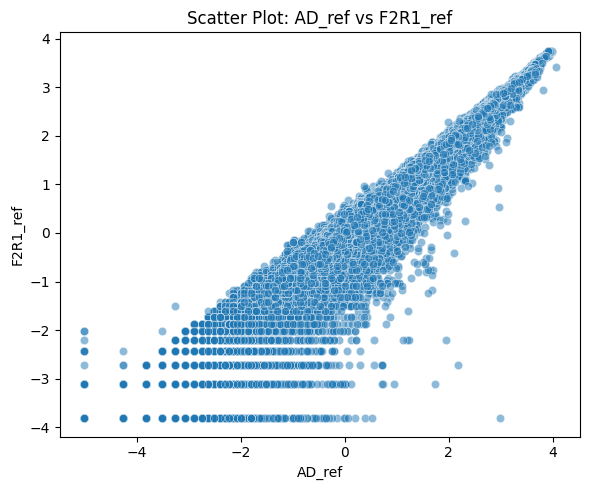

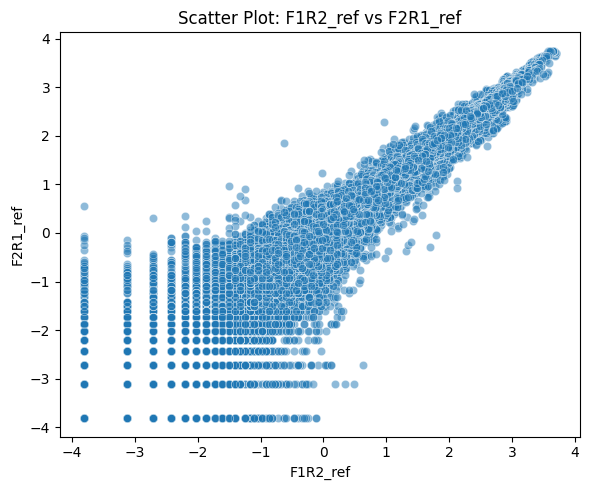

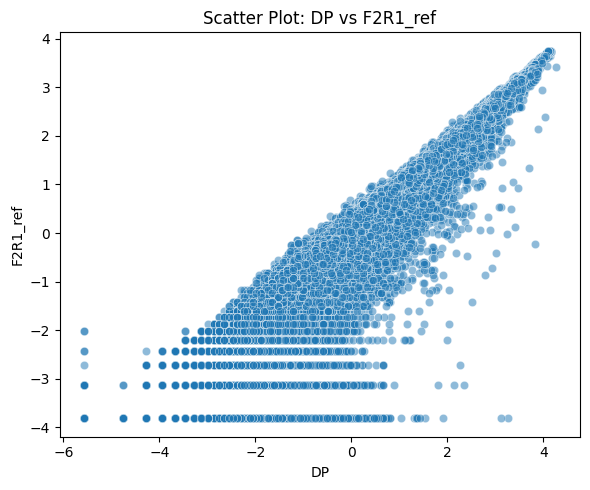

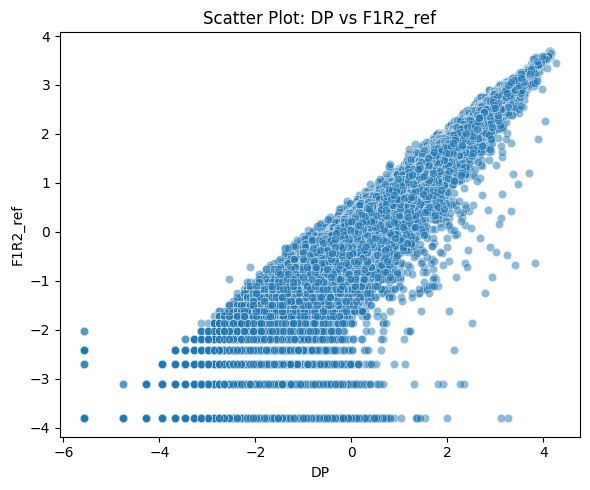

In [15]:
# Compute absolute correlation matrix and extract top pairs
corr_matrix_abs = corr_matrix.abs()
corr_pairs = (
    corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

# Show top 5 strongest correlations (excluding self-correlations)
top_pairs = corr_pairs.head(5).index.tolist()

for x, y in top_pairs:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(f"Scatter Plot: {x} vs {y}")
    plt.tight_layout()
    plt.show()